<img src="../images/phidp_kdp_comparison_cacti.png" width=700 alt="Dual-Pol Comparison"></img>

# Data Quality Check from the CACTI Field Campaign

## Overview

Within this notebook, we will cover:

1. How to access multiple datasets from the Atmospheric Radiation Measurment (ARM) user facility
1. How to create a multipanel plot
1. How to compare uncorrected vs. corrected data

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Required | Basic plotting |
| [Introduction to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Adding projections to your plot |
| [Py-ART Basics](../foundations/pyart-basics) | Required | IO/Visualization |
| [Py-ART Corrections](../foundations/pyart-corrections) | Required | Radar Corrections |
---

## Imports

In [2]:
import os

import act
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import pyart
import glob

## Grab Data from the ARM Data Portal

One of the better cases of the CACTI field campaign was from November 11, 2018, where several intense storms traversed through the domain.

### The Cloud, Aerosol, and Complex Terrain Interactions (CACTI) Field Campaign

Data is available from the Atmospheric Radiation Measurment user facility, which helped to lead the CACTI field campaign in the Sierras de Cordoba region of Argentina.

The data are available from the ARM data portal (https://adc.arm.gov/).

We are interested in the corrected C-band radar data, which has the original and corrected data, with the datastream name
* **`corcsapr2cmacppiM1.c1`**

### Use the ARM Live API to Download the Data, using ACT

The Atmospheric Data Community Toolkit (ACT) has a helpful module to interface with the data server:
* [Download Data API](https://arm-doe.github.io/ACT/API/generated/act.discovery.download_data.html#act.discovery.download_data)

### Setup our Download Query
Before downloading our data, we need to make sure we have an ARM Data Account, and ARM Live token. Both of these can be found using this link:
- [ARM Live Signup](https://adc.arm.gov/armlive/livedata/home)

Once you sign up, you will see your token. Copy and replace that where we have `arm_username` and `arm_password` below.

In [5]:
arm_username = os.getenv("ARM_USERNAME")
arm_password = os.getenv("ARM_PASSWORD")

datastream = "corcsapr2cmacppiM1.c1"

start_date = "2018-11-11T03:00:00"
end_date = "2018-11-11T03:15:00"

In [6]:
csapr_files = act.discovery.download_data(arm_username,
                                          arm_password,
                                          datastream,
                                          start_date,
                                          end_date,
                                         )

[DOWNLOADING] corcsapr2cmacppiM1.c1.20181111.030003.nc


## Read in and Investigate our Radar Data

In [7]:
radar = pyart.io.read(csapr_files[0])

/Users/mgrover/git_repos/pyart/pyart/io/cfradial.py:376: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/Users/mgrover/git_repos/pyart/pyart/io/cfradial.py:376: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]


### List the available fields and plot the corrected and uncorrected data

In [14]:
sorted(list(radar.fields))

['attenuation_corrected_differential_reflectivity',
 'attenuation_corrected_differential_reflectivity_lag_1',
 'attenuation_corrected_reflectivity_h',
 'censor_mask',
 'classification_mask',
 'clutter_masked_velocity',
 'copol_correlation_coeff',
 'corrected_differential_phase',
 'corrected_differential_reflectivity',
 'corrected_reflectivity',
 'corrected_specific_diff_phase',
 'corrected_velocity',
 'cumulative_beam_blockage',
 'differential_phase',
 'differential_reflectivity',
 'differential_reflectivity_lag_1',
 'filtered_corrected_differential_phase',
 'filtered_corrected_specific_diff_phase',
 'gate_id',
 'ground_clutter',
 'height',
 'height_over_iso0',
 'mean_doppler_velocity',
 'mean_doppler_velocity_v',
 'normalized_coherent_power',
 'normalized_coherent_power_v',
 'partial_beam_blockage',
 'path_integrated_attenuation',
 'path_integrated_differential_attenuation',
 'rain_rate_A',
 'reflectivity',
 'reflectivity_v',
 'signal_to_noise_ratio',
 'signal_to_noise_ratio_copolar_h

### Plot a Quick-Look of Reflectivity and Velocity
Let's start by plotting our reflectivity and velocity fields, using a four panel plot showing the uncorrected and corrected fields. Notice how the data is masked, and the radial velocities are unfolded.

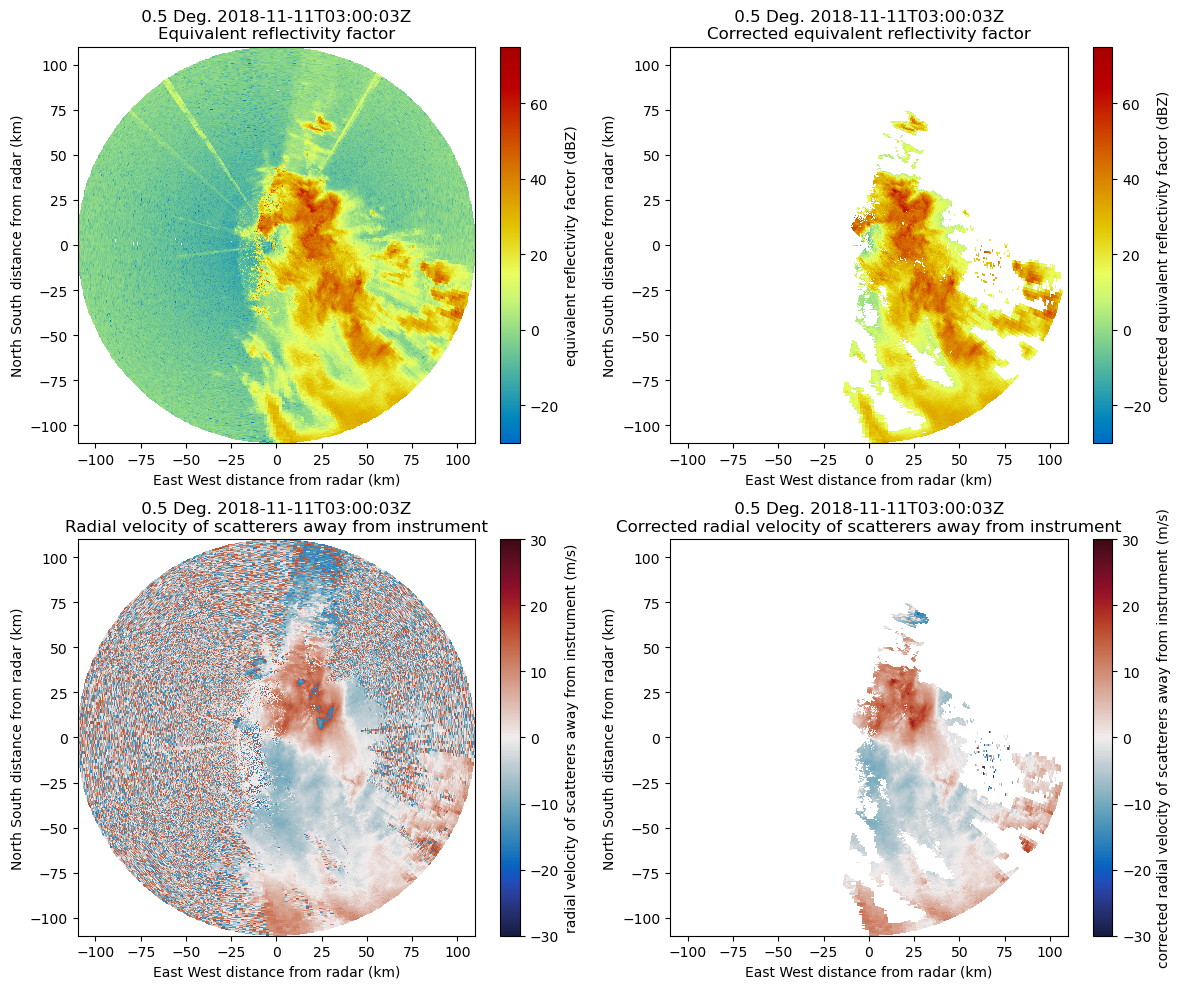

In [9]:
fig = plt.figure(figsize=(12,10))
display = pyart.graph.RadarDisplay(radar)
ax1 = plt.subplot(221)
display.plot_ppi("reflectivity", ax=ax1)

ax2 = plt.subplot(222)
display.plot_ppi("corrected_reflectivity", ax=ax2)

ax3 = plt.subplot(223)
display.plot_ppi("mean_doppler_velocity", vmin=-30, vmax=30, cmap='pyart_balance', ax=ax3)

ax4 = plt.subplot(224)
display.plot_ppi("corrected_velocity", vmin=-30, vmax=30, cmap='pyart_balance', ax=ax4)

plt.tight_layout()

## Investigate Dual-Pol Variables
Several of the variables in this file are dual-polarization products, meaning it uses pulses in both the horizontal and vertical direction, and derives fields from this additional information.

![Dual pol idea](https://www.weather.gov/images/ffc/dualpol_radar.gif)

### Differential Phase Shift (PhiDP) and Specific Differential Phase (KDP)
One of these dual-pol variables is called the **Differential Phase Shift (PhiDP)**, which is the difference in 2-way attenuation for the horizontal and vertical radar pulses moving through some target. This gives us information about the shape and concentration of the features we are interested in! It is also used to calculate the specific differential phase (KDP), which is the gradient in PhiDP, where positive KDP values indicate greater phase shift in the horizontal. Higher values of KDP can indicate an increase in the size and concentration of rain drops.

### Compare Uncorrected and Corrected PhiDP and KDP
We start with the uncorrected fields, `specific_differential_phase` and `uncorrected_differential_phase`, and compare to the corrected fields `filtered_corrected_specific_diff_phase` and `filtered_corrected_differential_phase`.

Notice how much cleaner the corrected fields are, and how the noise has been filtered, leading a more analysis-ready dataset.

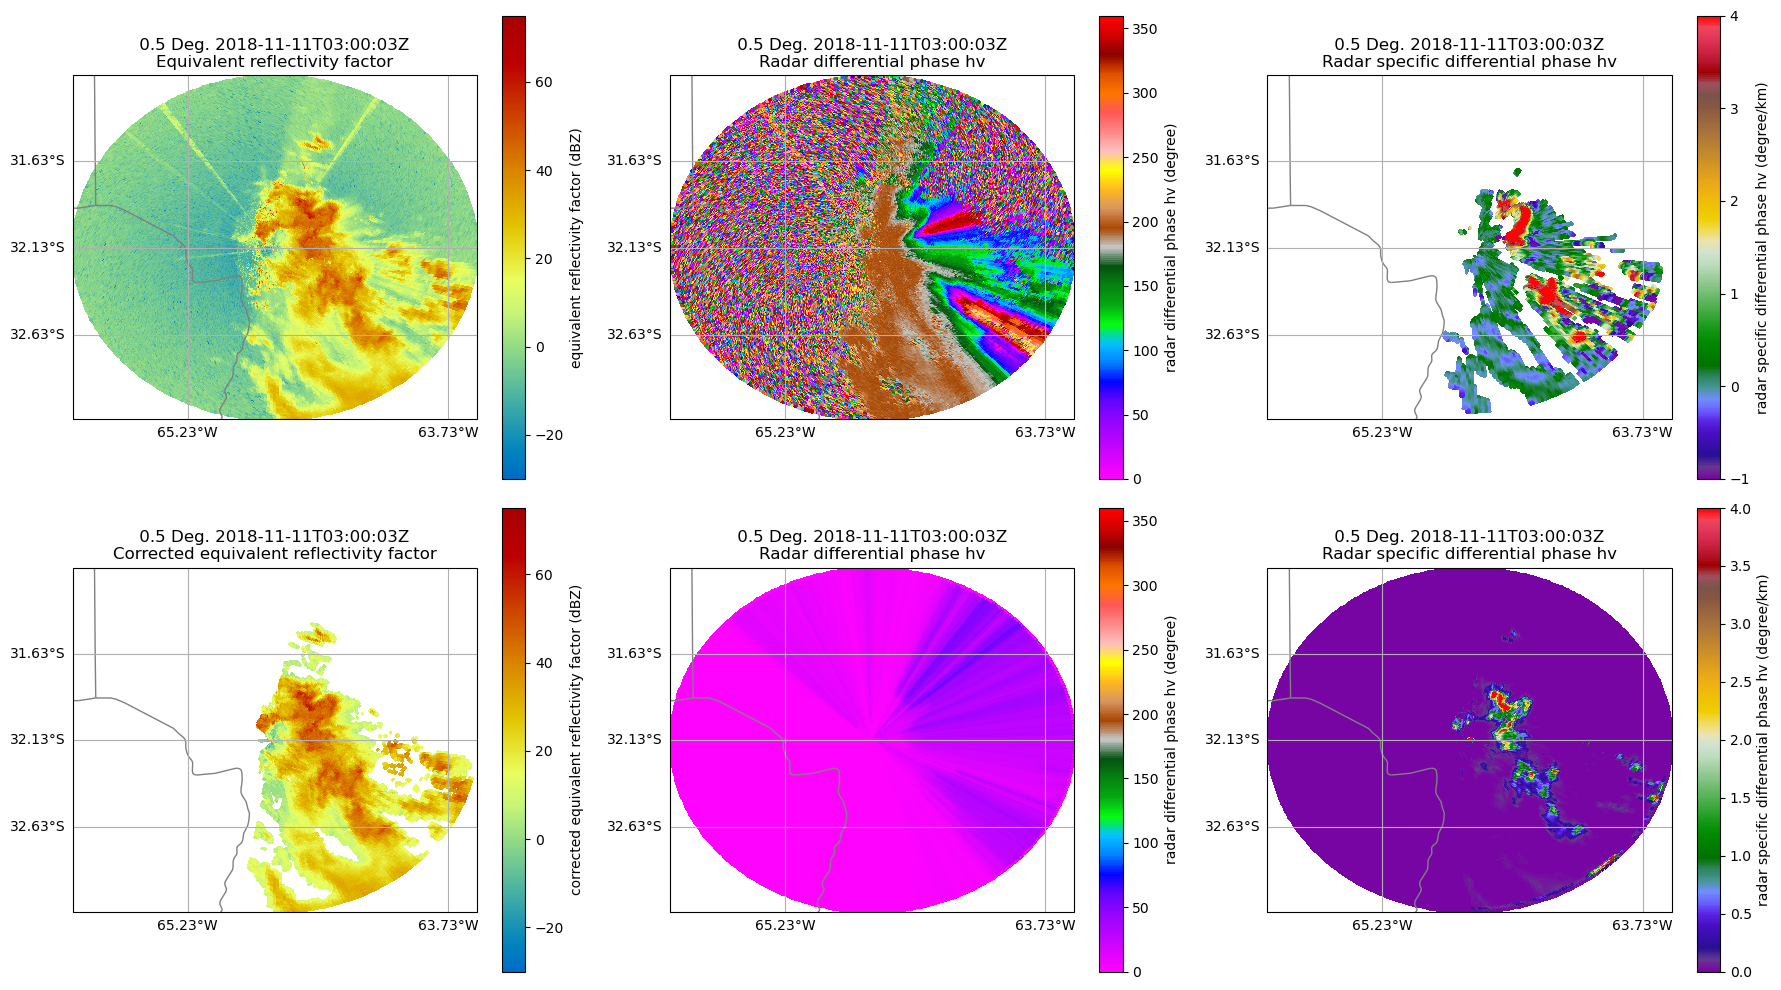

In [32]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=(18,10))

# Extract the latitude and longitude of the radar and use it for the center of the map
lat_center = round(radar.latitude['data'][0], 2)
lon_center = round(radar.longitude['data'][0], 2)

# Set the projection - in this case, we use a general PlateCarree projection
projection = ccrs.PlateCarree()

# Determine the ticks
lat_ticks = np.arange(lat_center-2, lat_center+2, .5)
lon_ticks = np.arange(lon_center-2, lon_center+2, 1.5)

ax1 = plt.subplot(231, projection=projection)
display.plot_ppi_map("reflectivity", 0, resolution='10m', ax=ax1, lat_lines=lat_ticks, lon_lines=lon_ticks)


ax3 = plt.subplot(232,projection=projection)
display.plot_ppi_map("differential_phase", 0, resolution='10m', ax=ax3, vmin=0, vmax=360, lat_lines=lat_ticks, lon_lines=lon_ticks)

ax3 = plt.subplot(233,projection=projection)
display.plot_ppi_map("specific_differential_phase", 0, resolution='10m', ax=ax3, vmin=-1, vmax=4, cmap='pyart_Carbone42', lat_lines=lat_ticks, lon_lines=lon_ticks)

ax4 = plt.subplot(234, projection=projection)
display.plot_ppi_map("corrected_reflectivity", 0, resolution='10m', ax=ax4, lat_lines=lat_ticks, lon_lines=lon_ticks)


ax5 = plt.subplot(235, projection=projection)
display.plot_ppi_map("filtered_corrected_differential_phase", 0, resolution='10m', ax=ax5, vmin=0, vmax=360, cmap='pyart_Wild25', lat_lines=lat_ticks, lon_lines=lon_ticks)

ax6 = plt.subplot(236,projection=projection)
display.plot_ppi_map("filtered_corrected_specific_diff_phase", 0, resolution='10m', ax=ax6, vmin=0, vmax=4, cmap='pyart_Carbone42', lat_lines=lat_ticks, lon_lines=lon_ticks)

plt.tight_layout()
plt.savefig('phidp_kdp_comparison_cacti.png', dpi=300, transparent=False)

### Create a Three Panel Figure Visualizing Reflectivity, Gate ID, and KDP
Now that we understand how valuable these corrections can be, let's create a summary figure, giving a quick overview of the scatterers and associated polarimetric fields.

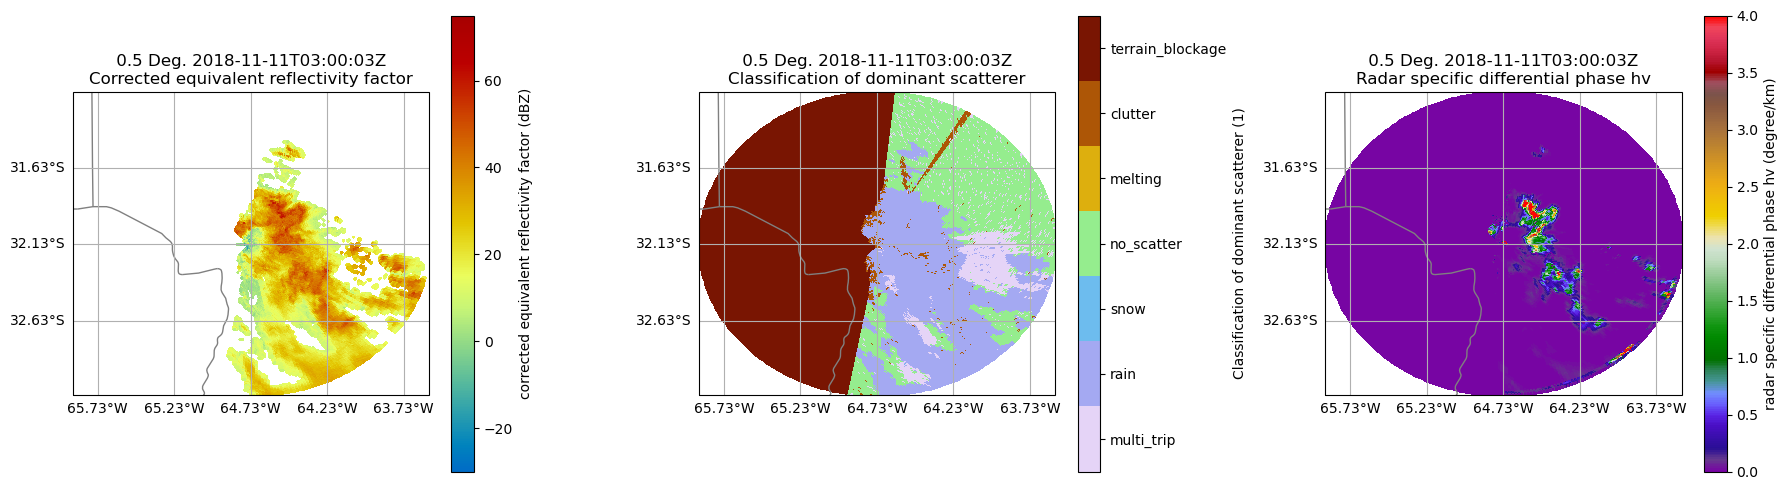

In [33]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=(18,5))

# Extract the latitude and longitude of the radar and use it for the center of the map
lat_center = round(radar.latitude['data'][0], 2)
lon_center = round(radar.longitude['data'][0], 2)

projection = ccrs.PlateCarree()

# Determine the ticks
lat_ticks = np.arange(lat_center-2, lat_center+2, .5)
lon_ticks = np.arange(lon_center-2, lon_center+2, .5)

ax1 = plt.subplot(131, projection=projection)
display.plot_ppi_map("corrected_reflectivity", 0, resolution='10m', ax=ax1, lat_lines=lat_ticks, lon_lines=lon_ticks)


ax2 = plt.subplot(132, projection=projection)
gate_ids = radar.fields["gate_id"]["flag_meanings"].split(" ")
ticks = np.arange(len(gate_ids))
boundaries = np.arange(-0.5, len(gate_ids))
norm = mpl.colors.BoundaryNorm(boundaries, 256)
display.plot_ppi_map("gate_id", 0, ax=ax2, lat_lines=lat_ticks, resolution='10m', lon_lines=lon_ticks, cmap='pyart_LangRainbow12', ticks=ticks, norm=norm, ticklabs=gate_ids)

ax3 = plt.subplot(133,projection=projection)
display.plot_ppi_map("filtered_corrected_specific_diff_phase", 0, resolution='10m', ax=ax3, vmin=0, vmax=4, cmap='pyart_Carbone42', lat_lines=lat_ticks, lon_lines=lon_ticks)

plt.tight_layout()
plt.savefig('three_panel_summary_cacti.png', dpi=300, transparent=False)

---
## Summary
Within this example, we walked through how to access ARM data from a field campaign in Argentina, plot a quick look of the data, and compare corrected and uncorrected dual-pol variables!

### What's Next?
We will showcase other data workflow examples, including field campaigns in other regions and data access methods from other data centers.

## Resources and References
* [ARM Data Discovery](https://adc.arm.gov/discovery)
* [CACTI Field Campaign](https://www.arm.gov/research/campaigns/amf2018cacti)
* CSAPR Radar Data:
    - Bharadwaj, N., Collis, S., Hardin, J., Isom, B., Lindenmaier, I., Matthews, A., & Nelson, D. C-Band Scanning ARM Precipitation Radar (CSAPR2CFR). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1467901
* Py-ART:
    - Helmus, J.J. & Collis, S.M., (2016). The Python ARM Radar Toolkit (Py-ART), a Library for Working with Weather Radar Data in the Python Programming Language. Journal of Open Research Software. 4(1), p.e25. DOI: http://doi.org/10.5334/jors.119
* ACT:
    - Adam Theisen, Ken Kehoe, Zach Sherman, Bobby Jackson, Alyssa Sockol, Corey Godine, Max Grover, Jason Hemedinger, Jenni Kyrouac, Maxwell Levin, Michael Giansiracusa (2022). The Atmospheric Data Community Toolkit (ACT). Zenodo. DOI: https://doi.org/10.5281/zenodo.6712343